## (1) Lexer
* This Component is responsible for breaking the input into tokens.
* And it escape all spaces and newlines.
* and we implemented it mainly for 2 reasons:
    1. We will need to do parsing, and parsing on raw characters is ugly

    2. (Optional) We will need to handle escapes :
     Suppose you want to match the literal string '(', how
     would you do it ?
     If your regex engine doesn't handle escapes, you
     can't, but with escapes it's simply the regex "\("

In [29]:
# First of all we need to define all the tokens' types
DEBUG = True
from enum import Enum
class TokenTypes(Enum):
    OR = 1 
    Astrisk = 2 
    Plus = 3 
    QuestionMark = 4
    OpenSquareBracket = 5 
    ClosedSquareBracket = 6
    OpenBracket = 7
    ClosedBracket = 8
    Hiphen = 9 
    Dot = 10
    LiteralChar = 11

In [30]:
# now we need to define a class for the tokens 
class Token: 
    def __init__(self, tokenType, value):
        self.tokenType = tokenType
        self.value = value # the string value of the token, and is used in case of LiteralChar.

# we need to define a class for token stream, and a pointer, which is initialized to 0, because they will be used later by the 
class TokenStream: 
    def __init__ (self, tokenStream = [],tokenPointer=0): 
        self.tokenStream = tokenStream
        self.tokenPointer = tokenPointer
    def resetStream (self): 
        self.tokenStream = []
        self.tokenPointer = 0
    def advanceTokenPointer(self):
        self.tokenPointer += 1
    def getCurrentToken(self):
        return self.tokenStream[self.tokenPointer]
    

In [31]:
# Now lets implement the Lexer Class 
class Lexer: 
    @staticmethod
    def lexReg(regex:str): 
        '''
            This function is responsible for lexing the regular expression and returning a list of tokens.
            Input: 
                regex: a string representing the regular expression.
            Output:
                a list of tokens.
        '''
        # create a map which maps each character to its corresponding token type.
        conversionMap = { 
            '|': TokenTypes.OR,
            '*': TokenTypes.Astrisk,
            '+': TokenTypes.Plus,
            '?': TokenTypes.QuestionMark,
            '[': TokenTypes.OpenSquareBracket,
            ']': TokenTypes.ClosedSquareBracket,
            '(': TokenTypes.OpenBracket,
            ')': TokenTypes.ClosedBracket,
            '-': TokenTypes.Hiphen,
            '.': TokenTypes.Dot
            # LiteralCharacters are any other characters that are not in the map.
        }

        # define spaceChar and escapeChar
        spaceChar = ' '
        escapeChar = '\\'

        # initialize an empty token stream
        tokens = TokenStream()
        tokens.resetStream()

        # we will need to use two pointers approach, one holds the previous character, and the other holds the current character.
        previousChar = None
        for char in regex : 
            # skip all spaces
            if char == spaceChar: 
                continue
            # mark escapes
            if char == escapeChar: 
                # if the previous character is escape character, then we need to add the current character as a LiteralChar token.
                if previousChar == escapeChar:
                    tokens.tokenStream.append(Token(TokenTypes.LiteralChar, char))
                    # clear the mark. 
                    previousChar = None
                    continue
                # else, then we are preparing ourself to escape the next character.
                previousChar = char
                continue
            # check if the current character is in conversionMap and not preceeded with space 
            if char in conversionMap and previousChar != escapeChar: 
                # add the current character to the token stream
                tokens.tokenStream.append(Token(conversionMap[char], char))
            else: 
                # in this case we are trying to match the exact symbol, so we need to add it as a LiteralChar token.
                tokens.tokenStream.append(Token(TokenTypes.LiteralChar, char))
            previousChar = char
        return tokens


        

In [32]:
# Lets Test the Lexer 
def testLexer(): 
    # regex = 'a?b(cd|ef)[a-z]'
    
    regex = 'ab*c+de?(f|g|h)|mr|n|[pq]' #\\
    tokens = Lexer.lexReg(regex)
    for token in tokens.tokenStream: 
        print(token.tokenType, token.value)

testLexer()


TokenTypes.LiteralChar a
TokenTypes.LiteralChar b
TokenTypes.Astrisk *
TokenTypes.LiteralChar c
TokenTypes.Plus +
TokenTypes.LiteralChar d
TokenTypes.LiteralChar e
TokenTypes.QuestionMark ?
TokenTypes.OpenBracket (
TokenTypes.LiteralChar f
TokenTypes.OR |
TokenTypes.LiteralChar g
TokenTypes.OR |
TokenTypes.LiteralChar h
TokenTypes.ClosedBracket )
TokenTypes.OR |
TokenTypes.LiteralChar m
TokenTypes.LiteralChar r
TokenTypes.OR |
TokenTypes.LiteralChar n
TokenTypes.OR |
TokenTypes.OpenSquareBracket [
TokenTypes.LiteralChar p
TokenTypes.LiteralChar q
TokenTypes.ClosedSquareBracket ]


# (2) Regex_Parser

* Parser is a program that takes a sequence of tokens and produces a parse tree.
* but why do we need a parse tree? 
* The parse tree is a visual representation of the syntax of a program. It shows the structure of the program and how the different parts of the program relate to each other.
* Moreover, it allow us to keep the precedence of the elements in the expression, consider this case: 
  * 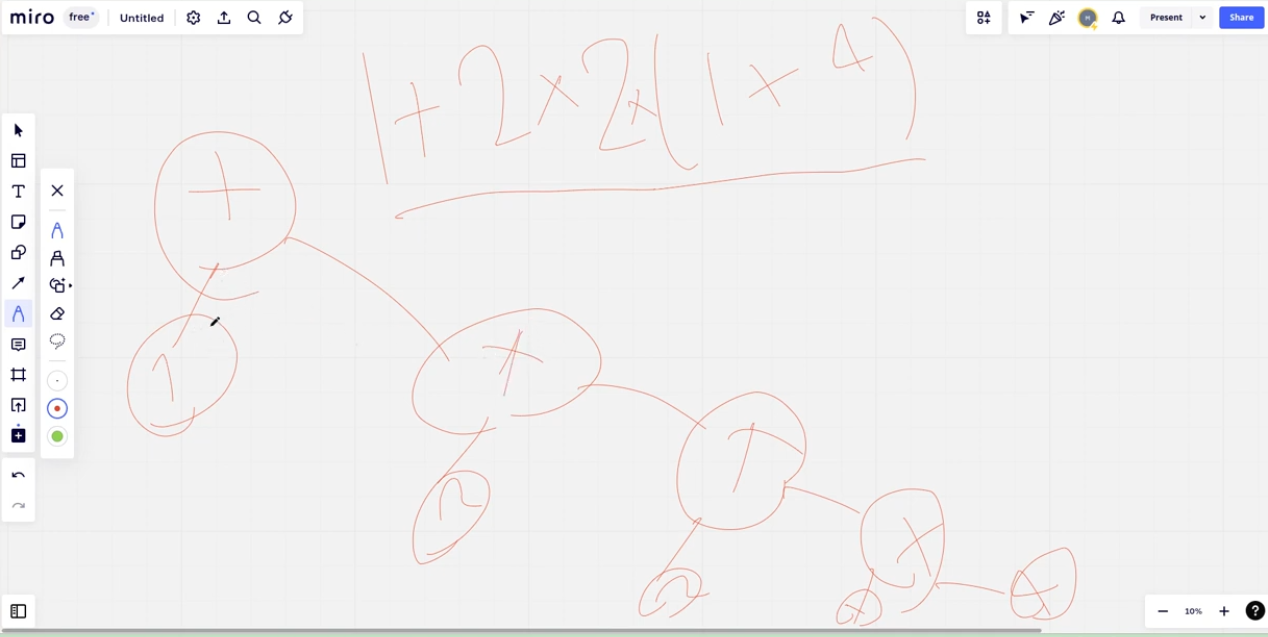
* In this case, if we used the naive approach, and moved from the beginning of the string, and just apply operations as we detects it, we will get a wrong result, because we shouldn't add 1 to 2, aw 2 should be firstly multiplied by its rightsside. 
* If we handled it as a string, we will make mistakes for sure.
* So now it makes sense to implement a parser, but how to do that?
* We have an algorithm called Recursive Descent Parser, which is a top-down parser that uses a set of recursive procedures to process the input.
* its steps are as follows: 
  * Define your AST-Node el node 3ndk shaklha 3aml ezay -> pointer msln w character w hakaza. 
  * b3den le kol operation 3ndk, m7tag te3ml class by-inheret mn el AST Node de.
  * ie: Or-AST-Node should be a node with two children, left and right, and its logic is that we consider only one of the children to be true, and the other is false.
  * ie: Sequence-AST-Node should be a node with two children, left and right, and its logic is that we should execute the left child first, then the right child. 
  * and so on till we cover all the cases
  * then define a leaf node -> Literal-Character-AST nodes, which is a node that has a value, and it is the end of the tree.
* After defining our hirarechal datastructure, we need to define a grammar to parse
* This is a method called Backus-Naur
  * 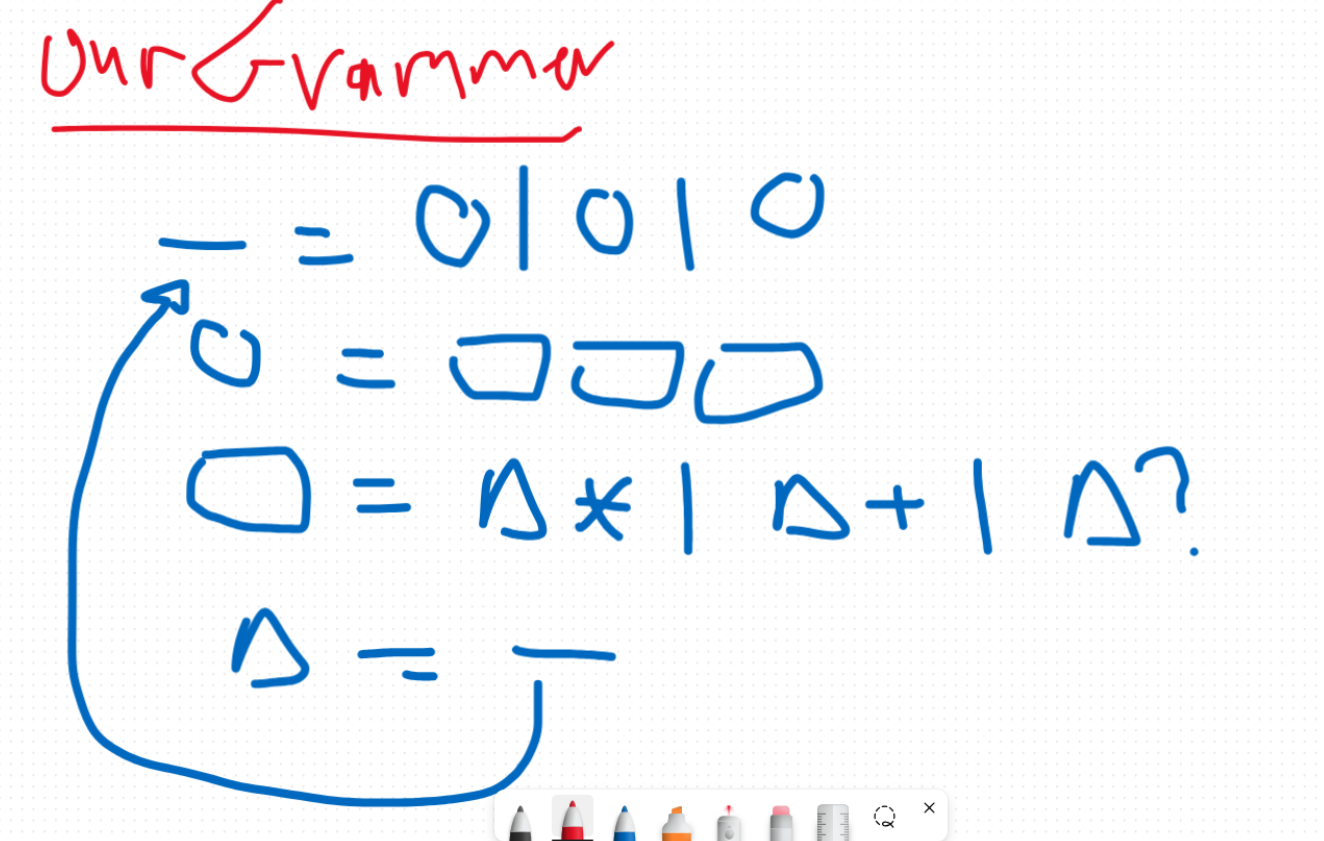
  * Our grammar should be in such hirarechal way.
      * we regex-expression : regex_or_expression
      * regex-or-expr ::= regex-seq-expr (OR_TOKEN regex-seq-expr)* 
      * regex-seq-expr ::= regex-quantified-expr (regex-quantified-expr)* 
      * regex-quantified-expr ::= regex-base-expr (STAR_TOKEN | PLUS_TOKEN | QUESTION_MARK_TOKEN)? 
      * regex-base-expr ::= LITERAL_CHAR_TOKEN  | [OPEN_SQUARE_BRACKET_TOKEN  square-bracket-content CLOSED_SQUARE_BRACKET_TOKEN ]| (OPEN_PARENTHESIS_TOKEN regex-expr CLOSED_PARENTHESIS_TOKEN )
      * square-bracket-content ::= square-bracket-element+ 
      * square-bracket-element ::= LITERAL_CHAR_TOKEN 
      * | LITERAL_CHAR_TOKEN DASH LITERAL_CHAR_TOKEN
* Now we need a code to implement this, Recursive descent says that, it is very easy to implement this grammar, by defining a function for each non-terminal in the grammar, and then call the functions recursively to parse the input.
* steps: 
  1. htbd2 t3ml function le kol element fe el grammar, ie: ehna olna 3ndna regex-exepression, yeb2a te3ml function esmha keda, w t5leha tnfzz bzbt elly enta katbu, fa keda el regExp => regex_or_expr(regex)
  2. w b3den tbd2 t3ml implementation lel regex_or_expr bnfs el tre2a, w tfdl keda l7d ma tewsl lel final literals.

# Procedures flow
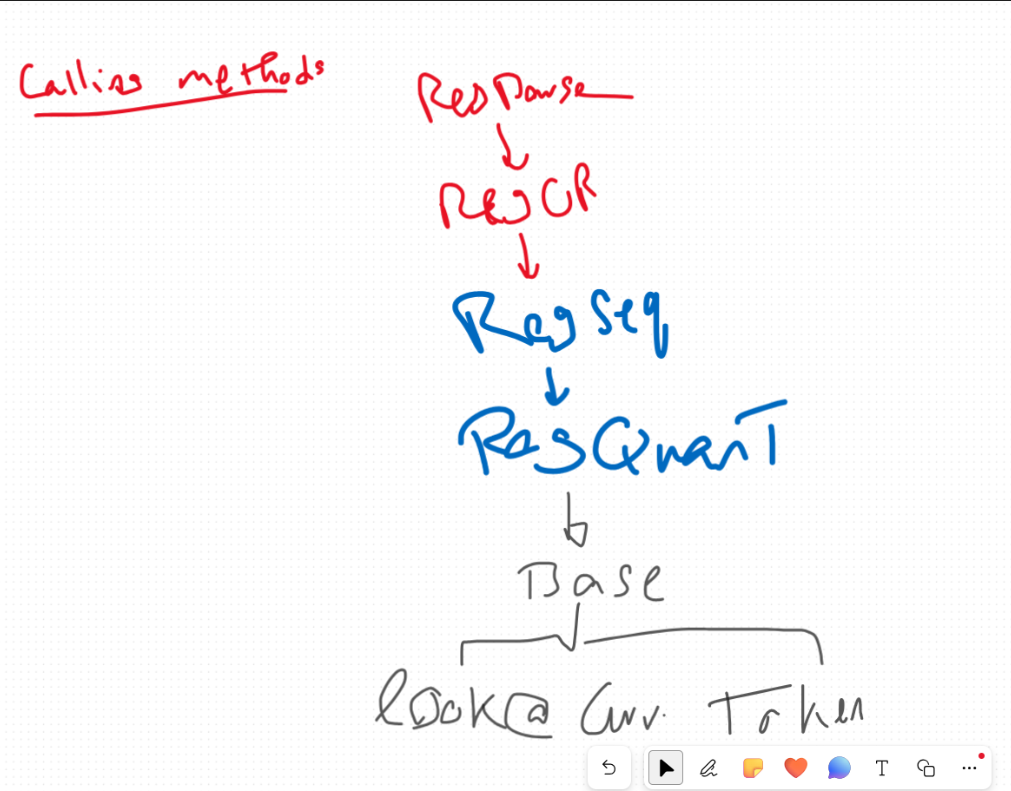

### Enough Talking, lets start implementing the code

In [45]:
# First we need to define our AST Nodes 
class AstNode: 
    pass # this is an abstract class 

'''
    What are our cases? 
        1. + -> One or more node class
        2. * -> Zero or more node class
        3. ? -> Zero or one class
        4. | -> OR class
        5. [] -> set of characters class
        6. abcd -> Sequence of characters class
        7. LiteralChar -> Literal Character class
'''
class PlusNode(AstNode):
    left: AstNode
    val: str
    def __init__(self, left):
        self.left = left
        self.val = '+'

class AstriskNode(AstNode):
    left: AstNode
    val: str
    def __init__(self, left):
        self.left = left
        self.val = '*'


class QuestionMarkNode(AstNode):
    left: AstNode
    val: str
    def __init__(self, left):
        self.left = left
        self.val = '?'
class OrNode(AstNode):
    left: AstNode
    right: AstNode
    val:str
    def __init__(self, left, right):
        self.left = left
        self.right = right
        self.val = '|'

class SetOfCharactersNode(AstNode):
    val:str
    characters: set  # maybe strings or pairs as in case of [0-9]
    def __init__(self, characters):
        self.characters = characters    
        self.val = '&&'

class SequenceOfCharactersNode(AstNode):
    left: AstNode
    right: AstNode
    val: str
    def __init__(self, left, right):
        self.left = left
        self.right = right
        self.val = '&&'

class LiteralCharNode(AstNode):
    value: str
    def __init__(self, value):
        self.value = value
        

### now lets define our grammar 

1. parse -> parseReg
2. parseReg -> parseOr
2. parseOr -> parseSeq (| parseSeq)*
2. parseSeq -> parseQuantified (parseQuantified)*
2. parseQuantified -> parseBase (+ | * | ?)?
2. parseBase -> LiteralChar | SetOfCharacters | ( parseReg )
2. so we just need to implement one function for each of those following the recursive descent parsing approach.


In [46]:
# 1. parseBase -> because it is our basecase, so we must implement the functions bottom up.
def parseSquareBrackets(tokenStream, tokenIdx):
    '''
        Our content may have different patterns: 
            1. a-z -> one range
            2. abc0-9 -> certain Literals and a range
            3. xyz -> certain Literals
            4. A-Z0-9 multiple Ranges 
            5. all above.
        how to handle them? 
        1. any range should be treated as a tuple of 2 characters
            first is the starting index
            second is the ending index. 
        2. any sequence of characters 
    '''
    characters = [] 
    prevIsDash = False
    # We Should iterate till we find a ] <= 
    while tokenStream[tokenIdx].tokenType != TokenTypes.ClosedSquareBracket:
        if tokenStream[tokenIdx].tokenType == TokenTypes.Hiphen:
            prevIsDash = True
        elif prevIsDash:
            # get the last appended char as the starting character
            startingChar = characters.pop()
            # get the current character as an ending character
            endingChar = tokenStream[tokenIdx].value
            # push in the characters a tuple
            characters.append((startingChar, endingChar))
            # set the prevIsDash back to False 
            prevIsDash = False
        elif tokenStream[tokenIdx].tokenType == TokenTypes.LiteralChar:
            characters.append(tokenStream[tokenIdx].value)
        tokenIdx += 1
    
    # here we should assign it to set, but I left it as List.
    return SetOfCharactersNode(characters), tokenIdx

def parseBase(tokenStream, tokenIdx):
    '''
        This function is responsible for parsing the base cases, or applying a recursive call on bracktes
        Implmenting this grammar:  parseBase -> LiteralChar | SetOfCharacters | ( parseReg )

        Input: 
            tokenStream: a list of tokens.
            tokenIdx: the current index of the token.
        Output:
            an AST node, and the new index
    '''

    # we have three cases, LiteralChar, SetOfCharacters, and ( parseReg )

    # Extracting the token 
    token:Token = tokenStream[tokenIdx]
    tokenIdx += 1 


    # LiteralChar
    if token.tokenType == TokenTypes.LiteralChar: 
        # print('character found' + token.value)
        # print('its index is ' + str(tokenIdx))
        node, idx = LiteralCharNode(token.value), tokenIdx 
        # print(node, idx)
        
        return node, idx
    
    # set of Characters. 
    if token.tokenType == TokenTypes.OpenSquareBracket: 
        # print('Parsing Square Brackets')
        sq, idx = parseSquareBrackets(tokenStream, tokenIdx) 
        # we need a utility function to parse the data inside the square brackets.
        # print(sq, idx)
        return sq, idx+1 # we need to skip the closed square bracket.

    if token.tokenType == TokenTypes.OpenBracket: 
        # print('Recursion')
        # we need to parse the regular expression inside the brackets.
        parsedReg, tokenIdx =  parseRegex(tokenStream, tokenIdx)
        # print('Recursion Done')
        # print(parsedReg, tokenIdx + 1)
        return parsedReg, tokenIdx+1 # we need to skip the closed bracket.
        

In [47]:
def parseQuantified(tokensStream, tokenIdx): 
    '''
        This function is responsible for parsing the quantified cases.
        it implements this grammar: 
            parseQuantified -> parseBase (+ | * | ?)?
    '''

    # first we assume that we have only one operand 
    leftOperand, tokenIdx = parseBase(tokensStream, tokenIdx)
    # print(leftOperand, tokenIdx)
    
    # now we need to check if there are more operands 
    if tokenIdx >= len(tokensStream):
        # no more operands, just return the leftOperand 
        return leftOperand, tokenIdx
    
    # now we have to check on the operator (*,+,?)
    token = tokensStream[tokenIdx]
    # print('the current token is: ' + token.value)
    '''
        el moshkela btb2a hena, enu byb2a shayef b, w de msh btb2a wla haga mn el t7t dol
    '''
    if token.tokenType == TokenTypes.QuestionMark:
        return QuestionMarkNode(leftOperand), tokenIdx + 1
    if token.tokenType == TokenTypes.Plus:
        return PlusNode(leftOperand), tokenIdx + 1
    if token.tokenType == TokenTypes.Astrisk:
        return AstriskNode(leftOperand), tokenIdx + 1
    
    # if we reached here, this implies that we finished the quantifiers. 
    return leftOperand, tokenIdx



In [48]:
def parseSequence(tokensStream, tokenIdx): 
    '''
        This function is responsible for parsing the sequence of characters.
        it implements this grammar: 
            parseSequence -> parseQuantified (parseQuantified)*
    '''
    # first we assume that we have only one operand
    leftOperand, tokenIdx = parseQuantified(tokensStream, tokenIdx)

    # now we need to check if we have more elements 
    if tokenIdx >= len(tokensStream):
        # no more elements 
        return leftOperand, tokenIdx
    
    # we need to continue parsing all sequence like abcd, or if we have operator we should also stop. 
    # to do so, we have to have a stoping condition
    # we will stop if we have a closed bracket, or an OR operator.
    while tokenIdx < len(tokensStream) and tokensStream[tokenIdx].tokenType not in [TokenTypes.OR, TokenTypes.ClosedBracket]:
        # print(tokensStream[tokenIdx].tokenType)
        # print(tokenIdx)
        rightOperand, tokenIdx = parseQuantified(tokensStream, tokenIdx) # token index is incremented here implecitly.
        leftOperand = SequenceOfCharactersNode(left=leftOperand,right= rightOperand) # recursive assignment, cascading the elemets in the leftOperand.
        # print(tokenIdx)
    return leftOperand, tokenIdx 


In [49]:
def parseOr (tokensStream, tokenIdx): 
    '''
        This function is responsible for parsing the OR operator.
        it implements this grammar: 
            parseOr -> parseSequence (| parseSequence)*
    '''
    # first we assume that we have only one operand
    leftOperand, tokenIdx = parseSequence(tokensStream, tokenIdx)

    # now we need to check if we have more elements
    if tokenIdx >= len(tokensStream): 
        return leftOperand, tokenIdx
    
    # now we still have elements, we just need to do recursion, as we see or operator 
    while tokenIdx < len(tokensStream) and tokensStream[tokenIdx].tokenType == TokenTypes.OR:
        rightOperand, tokenIdx = parseSequence(tokensStream, tokenIdx+1)
        leftOperand = OrNode(left =leftOperand,right= rightOperand)
    
    return leftOperand, tokenIdx

In [50]:
def parseRegex (tokensStream, index):
    '''
        This function should implement the grammar:
            parseReg -> parseOr
    ''' 
    return parseOr(tokensStream, index)

In [51]:
def parse(tokensStream): 
    expression, _ = parseRegex(tokensStream, 0)
    return expression

In [52]:
# Its time to test our logic. 
# regex = 'ab*c+de?(f|g|h)|mr|n|[pq]'
# regex = 'a+b' # this is similar to this (a+ . b) so it should be => a+b.
regex = '[a-z]nop'
tokens = Lexer.lexReg(regex)
ast:AstNode = parse(tokens.tokenStream)

# print a tree from left to right 
def printTree(node, level=0):
    if node is None:
        return
    if node.__class__.__name__ == 'SetOfCharactersNode':
        print('   '*level + str(node.characters))
        return
    if node.__class__.__name__ == 'LiteralCharNode':
        print('   '*level + node.value)
        return
    if(node.left):
       printTree(node.left, level+1)
    print('\t' * level + str(node))
    # print('   '*level + str(node.__class__.__name__))
    if node.__class__.__name__ in ['AstriskNode', 'PlusNode', 'QuestionMarkNode']:
        # all of these has no right operands. 
        return
    if(node.right):
        printTree(node.right, level+1)

printTree(ast)


         [('a', 'z')]
         n
      o
   p


### Converting recursive descent to postfix string

### Conversion algorithm:
1. function convertToPostfix(node):
   1. if node is operand:
      1.  output(node.value)
    2. else if node is operator:
       1. for each child in node.children:
            1. convertToPostfix(child)
        2. output(node.value)


In [53]:
postfixString = ''
def convertRecursiveDescentToPostfix (root: AstNode, postfixString:str): 
    # if no node.  
    if root == None: 
        return postfixString
    
    # if it was terminal character
    if root.__class__.__name__ == 'LiteralCharNode':
        postfixString += root.value
        return postfixString
    
    # if set of characters, add them as or operands
    if root.__class__.__name__ == 'SetOfCharactersNode':
        for element in root.characters: # in case of range => [0-9] and so on.
            if type(element) == tuple:
                startRange = element[0]
                endRange = element[1]
                # now I need to iterate from the start range to the end range, and add these elements as or
                for i in range(ord(startRange), ord(endRange)+1):
                    postfixString += chr(i) + '|'
            else: 
                postfixString += element + '|'

        # remove last character, it is excess (|)
        postfixString = postfixString[:-1]
        return postfixString

    # if it was an Sequence or OR node
    if root.__class__.__name__ in ['OrNode', 'SequenceOfCharactersNode']:
        # apply dfs, left first 
        postfixString = convertRecursiveDescentToPostfix(root.left, postfixString)
        # then right
        postfixString = convertRecursiveDescentToPostfix(root.right, postfixString)
        postfixString += root.val
        return postfixString
    
    # if it was any operator 
    if root.__class__.__name__ in ['AstriskNode', 'PlusNode', 'QuestionMarkNode']:
        # append the character first
        postfixString = convertRecursiveDescentToPostfix(root.left, postfixString)
        # then add the operatot. 
        postfixString += root.val
        return postfixString
    
postfixString = convertRecursiveDescentToPostfix(ast, postfixString)
print(postfixString)


a|b|c|d|e|f|g|h|i|j|k|l|m|n|o|p|q|r|s|t|u|v|w|x|y|zn&&o&&p&&


In [54]:
# Testing cell 
arr = [('a','b'), 'c','d']
for element in arr:
    if type(element) == tuple: 
        print(element[0], element[1])

a b
